In [1]:
using Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `~/Desktop/Work/Research/LEGO-project/LEGO-3D_Dyn`


In [2]:
import ForwardDiff as FD
using LinearAlgebra
using Plots

include(joinpath(@__DIR__,"helpers/DEL_dynamics.jl"));
include(joinpath(@__DIR__,"helpers/quaternions.jl"));

### Simulation paramters

In [3]:
function c(states, params_rbs)
  x1, q1 = states[1:3,1], states[4:7,1]
  cons_res = [x1 + quat2rot(q1) * params_rbs[1].joints[1];]
  return cons_res
end

function Dc(states, params_rbs)
  cons_jac = FD.jacobian(s -> c(s, params_rbs), states) * attitude_jacobian_block_matrix(states, params_rbs)
  return cons_jac
end 

Dc (generic function with 1 method)

In [4]:
h = 0.01 # 100 Hz
T_final = 5 # final time
T_hist = Array(0:h:T_final)
N = length(T_hist)

# model parameters
params_link1 = (m=1.0, J=Diagonal([0.1, 1.0, 1.0]), g=9.81, joints = [[0.5, 0, 0],]) # rigidbody parameters

m1 = params_link1.m
J1 = params_link1.J

# random initial orientation
q0 = [1, 0, 0, 0]
# q0 = normalize(rand(4))
x0 = [0, 0, 0]
v0 = [0, 0, 0]
ω0 = [0, 0, 0]

# initial conditions
link1_state0 = [x0; q0] # initial state of the rigidbody 
link1_vel0 = [v0; ω0] # initial velocity of the rigidbody
link1_momentum0 = vel2mom(link1_vel0, params_link1) # initial momentum of the rigidbody

# forcing terms
forces = [0, 0, 0]
torques = [0, 0, 0]
no_forcing = zeros(6) # no external forces

forcing = [forces; torques]

forcing_matrix = zeros(6, N)

# forcing_matrix[:, 5:15] .= forcing

# integrate
state_hist = zeros(7, N)
momentum_hist = zeros(6, N)

state_hist[:, 1] = link1_state0
momentum_hist[:, 1] = link1_momentum0

for i in 2:N
  λ = zeros(3)
  @show i
  state_hist[:, i], momentum_hist[:, i] = integrator_step(
    hcat(momentum_hist[:, i-1]),
    hcat(state_hist[:, i-1]),
    hcat(forcing_matrix[:, i-1]),
    hcat(forcing_matrix[:, i]),
    λ,
    [params_link1],
    h, 
    max_iters=50)
end

i = 2
i = 1
i = 2
i = 3
i = 3
i = 1
i = 2
i = 3
i = 4
i = 1
i = 2
i = 5
i = 1
i = 2
i = 3
i = 6
i = 1
i = 2
i = 3
i = 7
i = 1
i = 2
i = 3
i = 8
i = 1
i = 2
i = 3
i = 4
i = 9
i = 1
i = 2
i = 3
i = 4
i = 10
i = 1
i = 2
i = 3
i = 4
i = 11
i = 1
i = 2
i = 3
i = 4
i = 12
i = 1
i = 2
i = 3
i = 4
i = 13
i = 1
i = 2
i = 3
i = 4
i = 14
i = 1
i = 2
i = 3
i = 4
i = 15
i = 1
i = 2
i = 3
i = 4
i = 16
i = 1
i = 2
i = 3
i = 4
i = 17
i = 1
i = 2
i = 3
i = 4
i = 18
i = 1
i = 2
i = 3
i = 4
i = 19
i = 1
i = 2
i = 3
i = 4
i = 20
i = 1
i = 2
i = 3
i = 4
i = 21
i = 1
i = 2
i = 3
i = 4
i = 22
i = 1
i = 2
i = 3
i = 4
i = 23
i = 1
i = 2
i = 3
i = 4
i = 24
i = 1
i = 2
i = 3
i = 4
i = 25
i = 1
i = 2
i = 3
i = 4
i = 26
i = 1
i = 2
i = 3
i = 4
i = 27
i = 1
i = 2
i = 3
i = 4
i = 28
i = 1
i = 2
i = 3
i = 4
i = 29
i = 1
i = 2
i = 3
i = 4
i = 30
i = 1
i = 2
i = 3
i = 4
i = 31
i = 1
i = 2
i = 3
i = 4
i = 32
i = 1
i = 2
i = 3
i = 4
i = 33
i = 1
i = 2
i = 3
i = 4
i = 34
i = 1
i = 2
i = 3
i = 4
i = 35
i = 1
i = 2
i = 3
i 

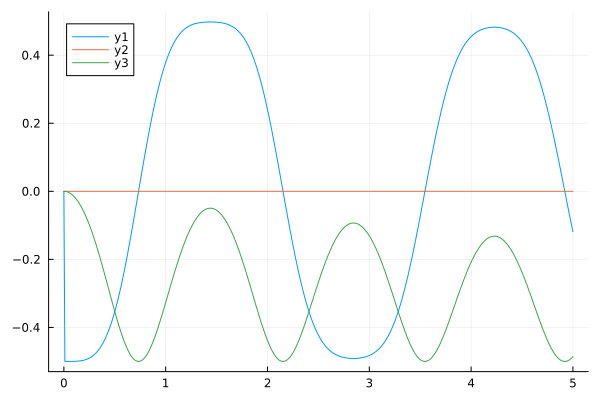

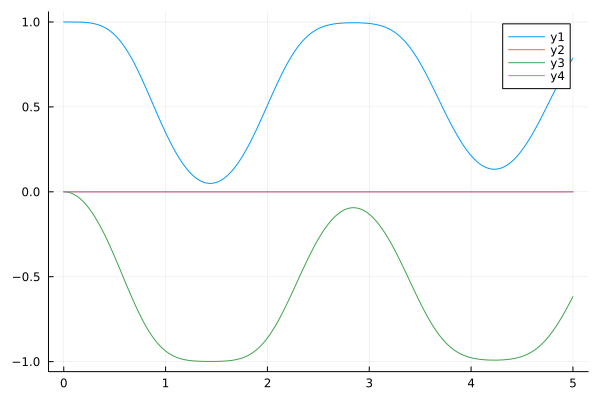

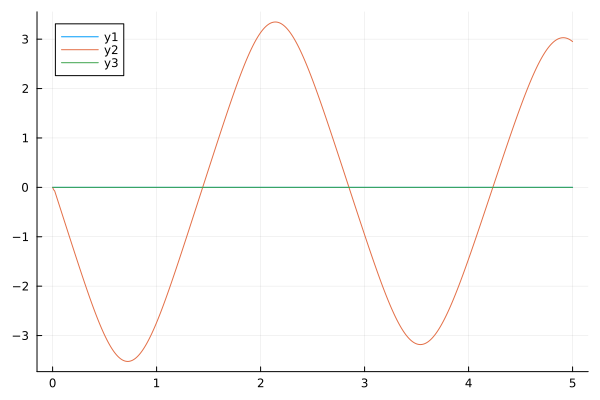

In [5]:
display(plot(T_hist, state_hist[1:3,:]'))

display(plot(T_hist, state_hist[4:7,:]'))

display(plot(T_hist, momentum_hist[4:6,:]'))

### Visualization

In [6]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations

In [7]:
vis = Visualizer()
render(vis)

┌ Info: Listening on: 127.0.0.1:8700, thread id: 1
└ @ HTTP.Servers /home/sman/.julia/packages/HTTP/sJD5V/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/sman/.julia/packages/MeshCat/0RCA3/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(RawFD(27) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007fcd93031e40, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (140524825633632, 140524825605008, 0)))))

In [10]:
delete!(vis)

green_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.8))
cylinder1 = Cylinder(Point(-0.5, 0, 0), Point(0.5, 0, 0), 0.1)
setobject!(vis["cylinder1"], cylinder1, green_material)


for k = 1:N
    # set position and attitude
    position1 = Translation(state_hist[1:3, k]...)
    attitude1 = LinearMap(UnitQuaternion(state_hist[4:7, k]))

    settransform!(vis["cylinder1"], compose(position1, attitude1))
    sleep(h)
end
